In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import en_vectors_web_lg
from IPython.display import display_markdown
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from shared import models
from shared.data import load_fine_food_reviews
from shared.models_store import Store
from machine_learning.cache import get_preprocessed_data
from machine_learning.plot_helpers import display_example_predictions, describe_data
from machine_learning.evaluation import evaluate_and_report

Using TensorFlow backend.


In [2]:
nlp = en_vectors_web_lg.load()

In [3]:
MAX_WORDS_IN_SENTENCE = 200
TEXT_COLUMN = "Text"
LIMIT = -1
SAVE_IN_STORE = True
dataset_id = 'food_normalized_{}_{}'.format(TEXT_COLUMN.lower(), LIMIT if LIMIT > 0 else 'all')

## Data loading and preview

### Loading

In [4]:
X, y = load_fine_food_reviews(limit=LIMIT, text_column=TEXT_COLUMN)


test_count = min(10000, int(0.25 * len(X)))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_count, random_state=42)

### Preview

In [5]:
describe_data(X, y)

display_markdown('### Train count: {}'.format(len(X_train)), raw=True)
display_markdown('### Test count:  {}'.format(len(X_test)), raw=True)

### Data sample

,X,y
0,"i have an absolute passion for deep, dark hot ...",0
1,"this drink is so ""super energy"" it's almost fr...",0
2,"i'm sticking with what used to be carnation, n...",0
3,aspertame causes alot of problems including pr...,0
4,i ordered these because my local pet store sto...,0
5,"generally speaking, i love mussels and was hop...",0
6,the price is too high compared to our local co...,0
7,i don't want to say these are awful but i won'...,0
8,my picky eater of a dog likes most of the smok...,0
9,i was so excited to try this after the reviews...,0


#### Text stats

count                                                164074
unique                                               128542
top       this review will make me sound really stupid, ...
freq                                                    199
Name: X, dtype: object

#### Words length stats

count    164074.000000
mean         82.579342
std          82.922558
min           3.000000
25%          35.000000
50%          59.000000
75%         100.000000
max        2520.000000
Name: X, dtype: float64

#### Most frequent words

like       74036
taste      40544
good       37422
product    35626
coffee     32142
great      28310
love       28247
food       27718
flavor     25370
tea        25328
buy        23548
tried      20772
little     20736
use        19303
dog        18023
eat        17755
find       17605
/>i        17247
bought     17105
try        16755
dtype: int64

#### Labels stats

count    164074.000000
mean          0.500000
std           0.500002
min           0.000000
25%           0.000000
50%           0.500000
75%           1.000000
max           1.000000
Name: y, dtype: float64

#### Labels counts

1    82037
0    82037
Name: y, dtype: int64

1    0.5
0    0.5
Name: y, dtype: float64

### Train count: 154074

### Test count:  10000

## Models

In [6]:
# helper for saving models for reuse in web application
store = Store(nlp, '../dist/store.json')
input_samples = [
    "We went there to eat dinner, and it was delicious",
    "One of the best suppers I've ever eaten",
    "Totally disgusting dish. I think cook made this with his eyes closed"
]

def train_model_and_display_results(model, X=X_train, y=y_train, Xt=X_test, yt=y_test, **train_params):
    display_markdown('## {}'.format(model.__class__.__name__), raw=True)
    
    display_markdown("#### Overview of created model", raw=True)
    display(model.summary())

    display_markdown('#### Training', raw=True)
    model.load_or_train(X, y, **train_params)

    display_markdown('#### Model results', raw=True)
    display_example_predictions(model, input_samples)
    train_metrics, train_roc = evaluate_and_report(model, X, y, preprocessed=True)
    test_metrics, test_roc = evaluate_and_report(model, Xt, yt, preprocessed=True)
    
    return {
        'test': {'metrics': test_metrics, 'roc': test_roc},
        'train': {'metrics': train_metrics, 'roc': train_roc}, 
    }

Loading cached data...
Loaded data from 'kerasmodel_food_normalized_text_all.h5'
Loading cached data...
Unable to load data, preprocessing...
Preprocessed and saved to 'kerasmodel_food_normalized_text_all_test.h5'


## KerasModel

#### Overview of created model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 198, 256)          230656    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 99, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 97, 128)           98432     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 48, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 46, 64)            24640     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
__________

None

#### Training

Loading model...
Model 'keras_food_normalized_text_all_644fa958.h5' loaded


#### Model results

#### Predicted scores

,score,text
0,9.706350e-01,"We went there to eat dinner, and it was delicious"
1,1.000000e+00,One of the best suppers I've ever eaten
2,3.952598e-10,Totally disgusting dish. I think cook made this with his eyes closed


#### Classification report for keras

             precision    recall  f1-score   support

   Negative     0.9941    0.9940    0.9941     77082
   Positive     0.9940    0.9941    0.9941     76968

avg / total     0.9941    0.9941    0.9941    154050



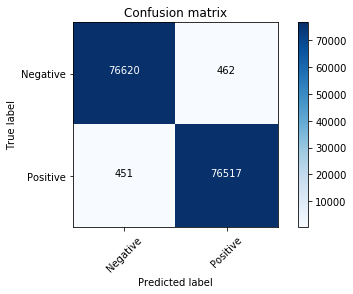

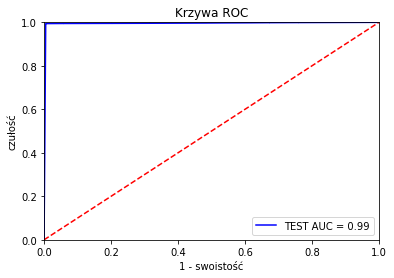

#### Classification report for keras

             precision    recall  f1-score   support

   Negative     0.9373    0.9337    0.9355      4946
   Positive     0.9353    0.9389    0.9371      5054

avg / total     0.9363    0.9363    0.9363     10000



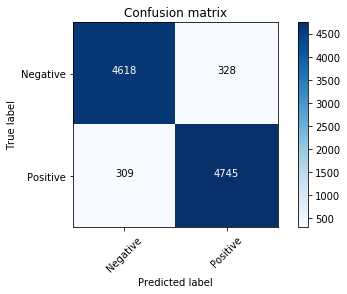

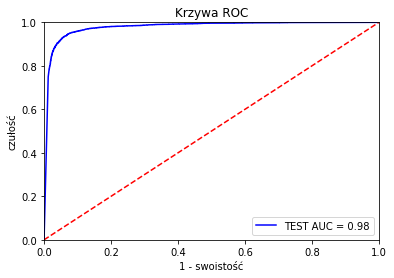

In [17]:
keras_model = models.KerasModel(
    nlp, 
    dataset_id, 
    max_words_in_sentence=MAX_WORDS_IN_SENTENCE, 
    epochs=50,
    id='tester2'
)

X_keras_preprocessed = get_preprocessed_data(keras_model, dataset_id, X_train)
X_keras_test_preprocessed = get_preprocessed_data(keras_model, dataset_id + '_test', X_test)

data = train_model_and_display_results(
    keras_model,
    X=X_keras_preprocessed, 
    Xt=X_keras_test_preprocessed, 
    preprocessed=True
)

if SAVE_IN_STORE:
    store.add_model(keras_model, "conv1d_food", "Food Reviews Conv1d", **data, metadata={
        'Dataset': 'Amazon Fine Food Reviews',
        'Training samples': len(X_train),
        'Description': "1D Convolutional network defined using Keras and trained on a publicly-available dataset"
    })



Loading cached data...
Loaded data from 'kerasmodel_food_normalized_text_all.h5'
Loading cached data...
Loaded data from 'kerasmodel_food_normalized_text_all_test.h5'


## KerasExperimentalModel

#### Overview of created model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 198, 64)           57664     
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 196, 64)           12352     
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 194, 64)           12352     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 97, 64)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 95, 64)            12352     
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 93, 64)            12352     
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 91, 64)            12352     
__________

None

#### Training

Loading model...
Model 'keras_experimental_food_normalized_text_all_48cb1e37.h5' loaded


#### Model results

#### Predicted scores

,score,text
0,1.000000e+00,"We went there to eat dinner, and it was delicious"
1,1.000000e+00,One of the best suppers I've ever eaten
2,1.717482e-23,Totally disgusting dish. I think cook made this with his eyes closed


#### Classification report for keras_experimental

             precision    recall  f1-score   support

   Negative     0.9823    0.9940    0.9882     77082
   Positive     0.9940    0.9821    0.9880     76968

avg / total     0.9881    0.9881    0.9881    154050



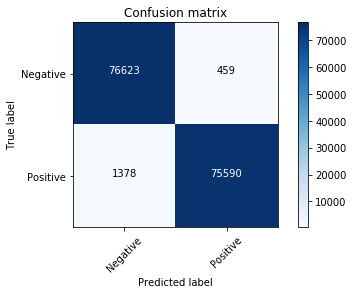

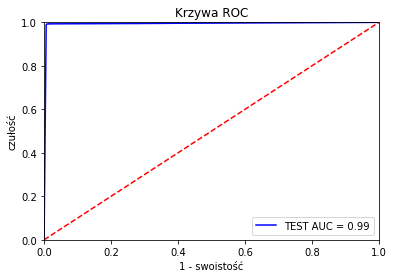

#### Classification report for keras_experimental

             precision    recall  f1-score   support

   Negative     0.9129    0.9533    0.9326      4946
   Positive     0.9522    0.9110    0.9311      5054

avg / total     0.9328    0.9319    0.9319     10000



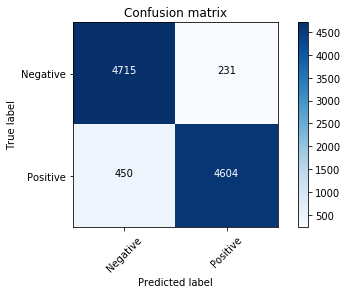

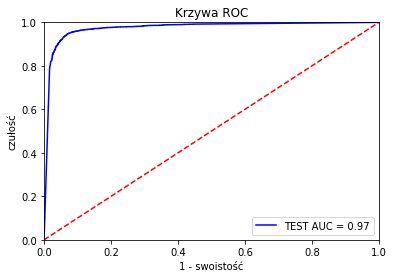

In [18]:
keras_model = models.KerasExperimentalModel(
    nlp, 
    dataset_id, 
    max_words_in_sentence=MAX_WORDS_IN_SENTENCE, 
    epochs=100,
    id='test'
)

X_keras_preprocessed = get_preprocessed_data(keras_model, dataset_id, X_train, filename='kerasmodel_{}.h5'.format(dataset_id))
X_keras_test_preprocessed = get_preprocessed_data(keras_model, dataset_id + '_test', X_test, filename='kerasmodel_{}_test.h5'.format(dataset_id))

data = train_model_and_display_results(
    keras_model,
    X=X_keras_preprocessed, 
    Xt=X_keras_test_preprocessed, 
    preprocessed=True
)

if SAVE_IN_STORE:
    store.add_model(keras_model, "conv1d_experiment_food", "Food Reviews Conv1d v2", **data, metadata={
        'Dataset': 'Amazon Fine Food Reviews',
        'Training samples': len(X_train),
        'Description': "1D Convolutional network defined using Keras and trained on a publicly-available dataset"
    })

# we need memory for further processing


Loading cached data...
Loaded data from 'kerasmodel_food_normalized_text_all.h5'
Loading cached data...
Loaded data from 'kerasmodel_food_normalized_text_all_test.h5'


## KerasDeepModel

#### Overview of created model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_19 (Conv1D)           (None, 198, 96)           86496     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 99, 96)            0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 99, 96)            0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 97, 96)            27744     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 48, 96)            0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 48, 96)            0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 46, 96)            27744     
__________

None

#### Training

Loading model...
Model 'keras_deep_food_normalized_text_all_495b2f6f.h5' loaded


#### Model results

#### Predicted scores

,score,text
0,0.649821,"We went there to eat dinner, and it was delicious"
1,0.649821,One of the best suppers I've ever eaten
2,0.000216,Totally disgusting dish. I think cook made this with his eyes closed


#### Classification report for keras_deep

             precision    recall  f1-score   support

   Negative     0.9544    0.8959    0.9242     77082
   Positive     0.9017    0.9571    0.9286     76968

avg / total     0.9281    0.9265    0.9264    154050



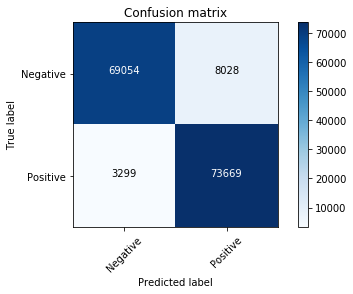

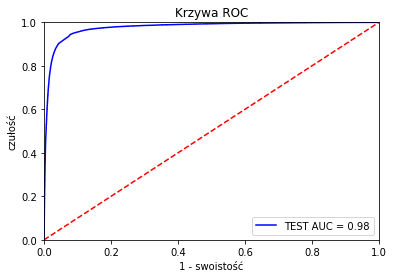

#### Classification report for keras_deep

             precision    recall  f1-score   support

   Negative     0.9337    0.8651    0.8981      4946
   Positive     0.8769    0.9398    0.9073      5054

avg / total     0.9050    0.9029    0.9027     10000



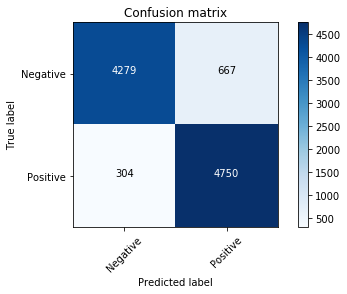

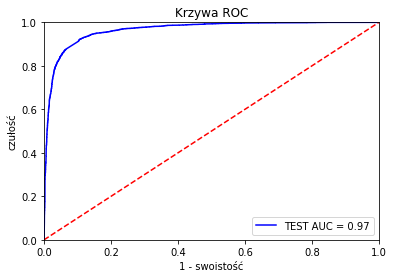

In [19]:
keras_model = models.KerasDeepModel(
    nlp, 
    dataset_id, 
    max_words_in_sentence=MAX_WORDS_IN_SENTENCE, 
    epochs=50
)

X_keras_preprocessed = get_preprocessed_data(keras_model, dataset_id, X_train, filename='kerasmodel_{}.h5'.format(dataset_id))
X_keras_test_preprocessed = get_preprocessed_data(keras_model, dataset_id + '_test', X_test, filename='kerasmodel_{}_test.h5'.format(dataset_id))

data = train_model_and_display_results(
    keras_model,
    X=X_keras_preprocessed, 
    Xt=X_keras_test_preprocessed, 
    preprocessed=True
)

if SAVE_IN_STORE:
    store.add_model(keras_model, "conv1d_deep_food", "Food Reviews Conv1d Deep", **data, metadata={
        'Dataset': 'Amazon Fine Food Reviews',
        'Training samples': len(X_train),
        'Description': "1D Convolutional network defined using Keras and trained on a publicly-available dataset"
    })

# we need memory for further processing
del X_keras_preprocessed
del X_keras_test_preprocessed

In [7]:
# preprocessed data for all sklearn-based models

model = models.SklearnModel(nlp, dataset_id, max_words_in_sentence=MAX_WORDS_IN_SENTENCE)
X_sklearn_preprocessed = get_preprocessed_data(model, dataset_id, X_train)
X_sklearn_test_preprocessed = get_preprocessed_data(model, dataset_id + '_test', X_test)

Loading cached data...
Loaded data from 'sklearnmodel_food_normalized_text_all.h5'
Loading cached data...
Loaded data from 'sklearnmodel_food_normalized_text_all_test.h5'


## SVCModel

#### Overview of created model

None

#### Training

Loading model...
Model 'svc_food_normalized_text_all_80e28a4f.pkl' loaded


#### Model results

#### Predicted scores

,score,text
0,0.980384,"We went there to eat dinner, and it was delicious"
1,0.996343,One of the best suppers I've ever eaten
2,0.015224,Totally disgusting dish. I think cook made this with his eyes closed


#### Classification report for svc

             precision    recall  f1-score   support

   Negative     0.8135    0.8378    0.8254      9931
   Positive     0.8351    0.8105    0.8226     10069

avg / total     0.8244    0.8240    0.8240     20000



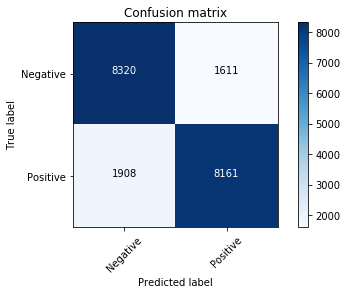

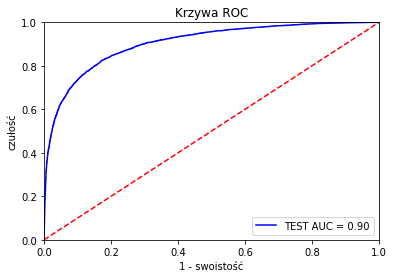

#### Classification report for svc

             precision    recall  f1-score   support

   Negative     0.8086    0.8346    0.8214      4946
   Positive     0.8329    0.8067    0.8196      5054

avg / total     0.8209    0.8205    0.8205     10000



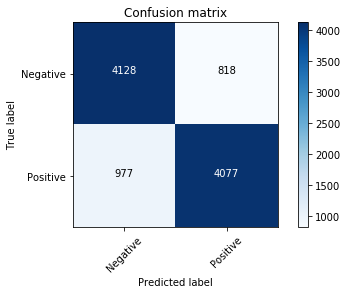

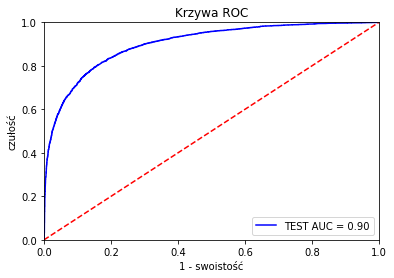

In [8]:
# it's almost impossible to train SVC on full dataset due to time complexity
svc_limit = min(20000, len(X_sklearn_preprocessed))
svc_model = models.SVCModel(
    nlp, dataset_id, 
    max_words_in_sentence=MAX_WORDS_IN_SENTENCE, 
    kernel="linear", C=0.025,
    probability=True)

data = train_model_and_display_results(
    svc_model,
    X_sklearn_preprocessed[:svc_limit], 
    y_train[:svc_limit], 
    X_sklearn_test_preprocessed,
    y_test,
    preprocessed=True
)

if SAVE_IN_STORE:
    store.add_model(svc_model, "svc_food", "Food Reviews SVC", metadata={
        'Dataset': 'Amazon Fine Food Reviews',
        'Training samples': svc_limit,
        'Description': "SVM algorithm from Sklearn package. Trained on a reduced dataset due to O(n^2) time complexity"
    }, **data)


## DecisionTreeModel

#### Overview of created model

None

#### Training

Loading model...
Model 'decisiontreeclassifier_food_normalized_text_all_5099b258.pkl' loaded


#### Model results

#### Predicted scores

,score,text
0,0.643118,"We went there to eat dinner, and it was delicious"
1,0.945964,One of the best suppers I've ever eaten
2,0.472035,Totally disgusting dish. I think cook made this with his eyes closed


#### Classification report for decisiontreeclassifier

             precision    recall  f1-score   support

   Negative     0.7383    0.7411    0.7397     77082
   Positive     0.7397    0.7370    0.7383     76968

avg / total     0.7390    0.7390    0.7390    154050



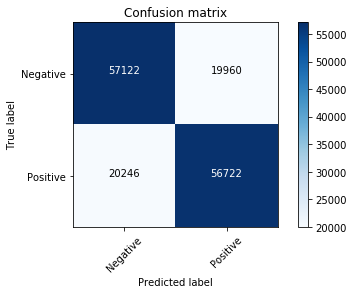

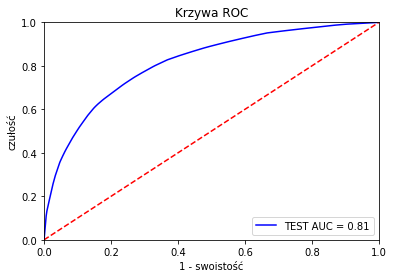

#### Classification report for decisiontreeclassifier

             precision    recall  f1-score   support

   Negative     0.7223    0.7327    0.7275      4946
   Positive     0.7347    0.7244    0.7295      5054

avg / total     0.7286    0.7285    0.7285     10000



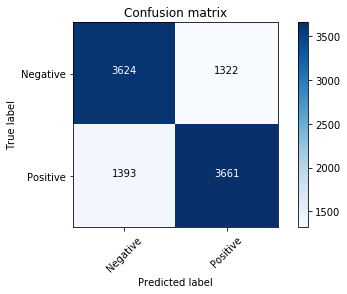

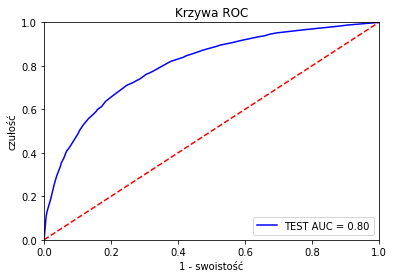

In [9]:
decision_tree_model = models.DecisionTreeModel(
    nlp, dataset_id, 
    max_words_in_sentence=MAX_WORDS_IN_SENTENCE, 
    max_depth=6)

data = train_model_and_display_results(
    decision_tree_model, 
    X=X_sklearn_preprocessed,
    Xt=X_sklearn_test_preprocessed,
    preprocessed=True)

if SAVE_IN_STORE:
    store.add_model(decision_tree_model, "decision_tree_food", "Food Reviews Decision Tree", **data, metadata={
        'Dataset': 'Amazon Fine Food Reviews',
        'Training samples': len(X_sklearn_preprocessed),
        'Description': "Decision Tree algorithm from Sklearn package."
    })

## RandomForestModel

#### Overview of created model

None

#### Training

Loading model...
Model 'randomforestclassifier_food_normalized_text_all_00997db5.pkl' loaded


#### Model results

#### Predicted scores

,score,text
0,0.713557,"We went there to eat dinner, and it was delicious"
1,0.764379,One of the best suppers I've ever eaten
2,0.369755,Totally disgusting dish. I think cook made this with his eyes closed


#### Classification report for randomforestclassifier

             precision    recall  f1-score   support

   Negative     0.9201    0.9433    0.9315     77082
   Positive     0.9417    0.9179    0.9297     76968

avg / total     0.9309    0.9306    0.9306    154050



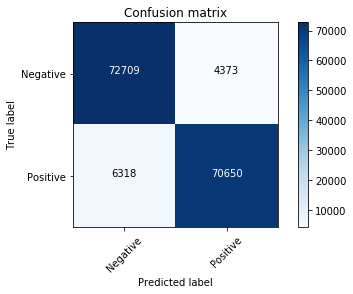

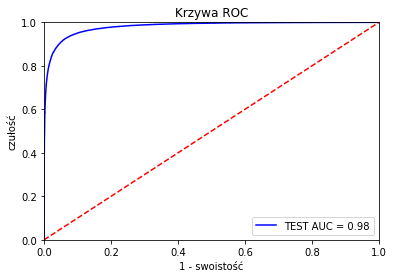

#### Classification report for randomforestclassifier

             precision    recall  f1-score   support

   Negative     0.8417    0.8684    0.8548      4946
   Positive     0.8671    0.8401    0.8534      5054

avg / total     0.8545    0.8541    0.8541     10000



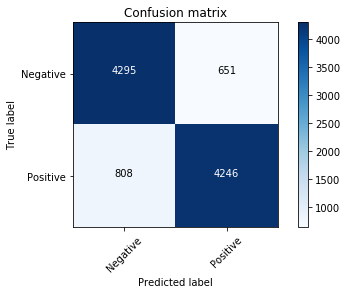

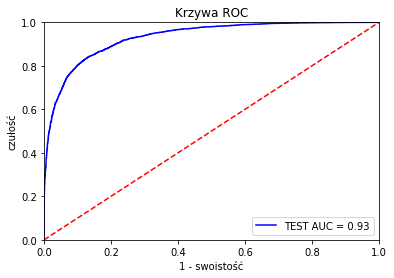

In [8]:
random_forest_model = models.RandomForestModel(
    nlp, dataset_id, 
    max_words_in_sentence=MAX_WORDS_IN_SENTENCE,
    n_estimators=200,
    max_depth=12,
    max_features=40
)

data = train_model_and_display_results(
    random_forest_model, 
    X_sklearn_preprocessed, 
    y_train, 
    X_sklearn_test_preprocessed, 
    y_test, 
    preprocessed=True
)

if SAVE_IN_STORE:
    store.add_model(random_forest_model, "random_forest_food", "Food Reviews Random Forest", **data, metadata={
        'Dataset': 'Amazon Fine Food Reviews',
        'Training samples': len(X_sklearn_preprocessed),
        'Description': "Random Forest algorithm from Sklearn package."
    })

## MLPModel

#### Overview of created model

None

#### Training

Loading model...
Model 'mlpclassifier_food_normalized_text_all_75b9bd09.pkl' loaded


#### Model results

#### Predicted scores

,score,text
0,0.999259,"We went there to eat dinner, and it was delicious"
1,1.000000,One of the best suppers I've ever eaten
2,0.000023,Totally disgusting dish. I think cook made this with his eyes closed


#### Classification report for mlpclassifier

             precision    recall  f1-score   support

   Negative     0.9095    0.9421    0.9255     77082
   Positive     0.9398    0.9062    0.9227     76968

avg / total     0.9247    0.9241    0.9241    154050



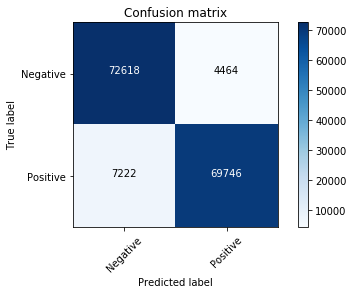

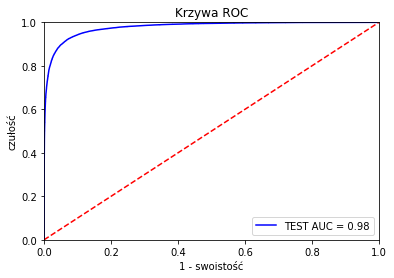

#### Classification report for mlpclassifier

             precision    recall  f1-score   support

   Negative     0.8649    0.9036    0.8838      4946
   Positive     0.9013    0.8619    0.8812      5054

avg / total     0.8833    0.8825    0.8825     10000



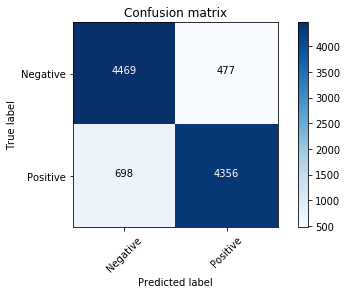

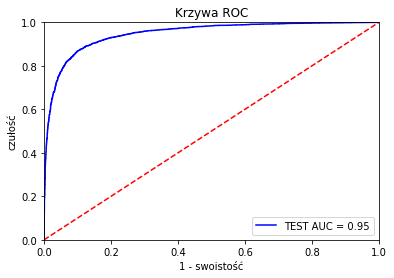

In [10]:
mlp_model = models.MLPModel(
    nlp, dataset_id,
    max_words_in_sentence=MAX_WORDS_IN_SENTENCE, 
    hidden_layer_sizes=[50, 50], 
    max_iter=100, 
    verbose=True)

data = train_model_and_display_results(
    mlp_model,
    X=X_sklearn_preprocessed,
    Xt=X_sklearn_test_preprocessed,
    preprocessed=True
)

if SAVE_IN_STORE:
    store.add_model(mlp_model, "mlp_food", "Food Reviews Multi-Layer Perceptron", **data, metadata={
        'Dataset': 'Amazon Fine Food Reviews',
        'Training samples': len(X_sklearn_preprocessed),
        'Description': "MLP algorithm from Sklearn package, with 50x50 hidden layers sizes"
    })

## GaussianNBModel

#### Overview of created model

None

#### Training

Loading model...
Model 'gaussiannb_food_normalized_text_all_d41d8cd9.pkl' loaded


#### Model results

#### Predicted scores

,score,text
0,1.000000,"We went there to eat dinner, and it was delicious"
1,1.000000,One of the best suppers I've ever eaten
2,0.999997,Totally disgusting dish. I think cook made this with his eyes closed


#### Classification report for gaussiannb

             precision    recall  f1-score   support

   Negative     0.6913    0.7981    0.7408     77082
   Positive     0.7608    0.6430    0.6970     76968

avg / total     0.7260    0.7206    0.7189    154050



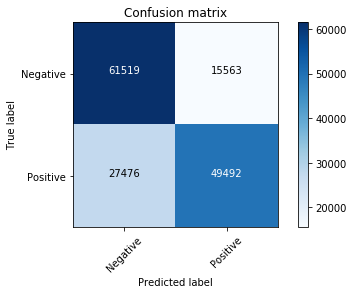

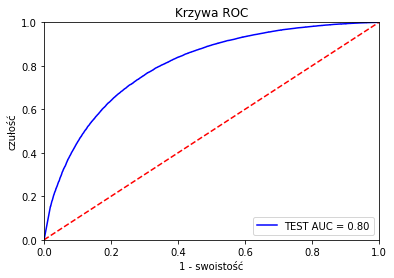

#### Classification report for gaussiannb

             precision    recall  f1-score   support

   Negative     0.6915    0.8031    0.7431      4946
   Positive     0.7711    0.6494    0.7050      5054

avg / total     0.7318    0.7254    0.7239     10000



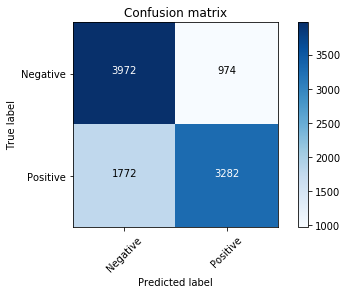

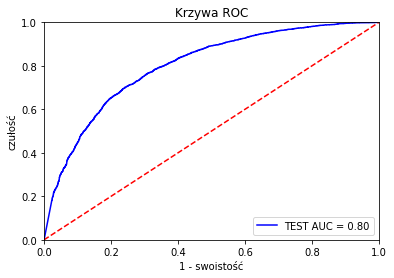

In [11]:
gaussian_nb_model = models.GaussianNBModel(
    nlp, dataset_id,
    max_words_in_sentence=MAX_WORDS_IN_SENTENCE, 
)

data = train_model_and_display_results(
    gaussian_nb_model,
    X=X_sklearn_preprocessed,
    Xt=X_sklearn_test_preprocessed,
    preprocessed=True
)


if SAVE_IN_STORE:
    store.add_model(gaussian_nb_model, "gnb_food", "Food Reviews Gaussian Naive Bayes", **data, metadata={
        'Dataset': 'Amazon Fine Food Reviews',
        'Training samples': len(X_sklearn_preprocessed),
        'Description': "GaussianNB algorithm from Sklearn package, default options"
    })

## AdaBoostModel

#### Overview of created model

None

#### Training

Loading model...
Model 'adaboostclassifier_food_normalized_text_all_d41d8cd9.pkl' loaded


#### Model results

#### Predicted scores

,score,text
0,0.514011,"We went there to eat dinner, and it was delicious"
1,0.518128,One of the best suppers I've ever eaten
2,0.489981,Totally disgusting dish. I think cook made this with his eyes closed


#### Classification report for adaboostclassifier

             precision    recall  f1-score   support

   Negative     0.7948    0.7984    0.7966     77082
   Positive     0.7972    0.7936    0.7954     76968

avg / total     0.7960    0.7960    0.7960    154050



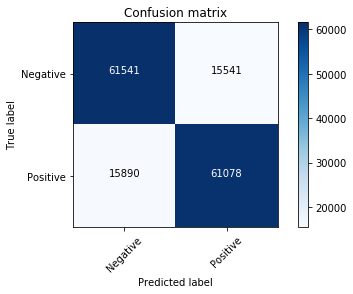

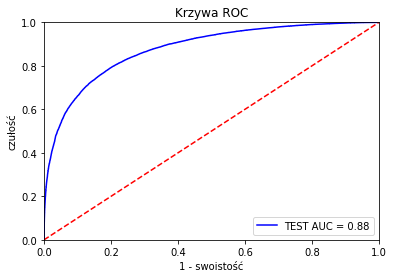

#### Classification report for adaboostclassifier

             precision    recall  f1-score   support

   Negative     0.7835    0.7962    0.7898      4946
   Positive     0.7973    0.7847    0.7910      5054

avg / total     0.7905    0.7904    0.7904     10000



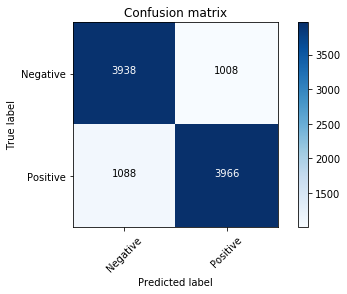

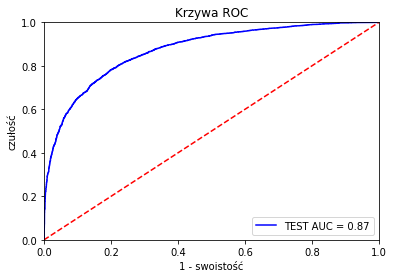

In [12]:
ada_boost_model = models.AdaBoostModel(
    nlp, dataset_id,
    max_words_in_sentence=MAX_WORDS_IN_SENTENCE
)

data = train_model_and_display_results(
    ada_boost_model,
    X=X_sklearn_preprocessed,
    Xt=X_sklearn_test_preprocessed,
    preprocessed=True
)

if SAVE_IN_STORE:
    store.add_model(ada_boost_model, "ada_food", "Food Reviews Ada Boost", **data, metadata={
        'Dataset': 'Amazon Fine Food Reviews',
        'Training samples': len(X_sklearn_preprocessed),
        'Description': "Ada Boost algorithm from Sklearn package, default options"
    })

## QuadraticDiscriminantAnalysisModel

#### Overview of created model

None

#### Training

Loading model...
Model 'quadraticdiscriminantanalysis_food_normalized_text_all_d41d8cd9.pkl' loaded


#### Model results

#### Predicted scores

,score,text
0,1.000000,"We went there to eat dinner, and it was delicious"
1,1.000000,One of the best suppers I've ever eaten
2,0.325744,Totally disgusting dish. I think cook made this with his eyes closed


#### Classification report for quadraticdiscriminantanalysis

             precision    recall  f1-score   support

   Negative     0.7838    0.8717    0.8254     77082
   Positive     0.8553    0.7591    0.8044     76968

avg / total     0.8195    0.8155    0.8149    154050



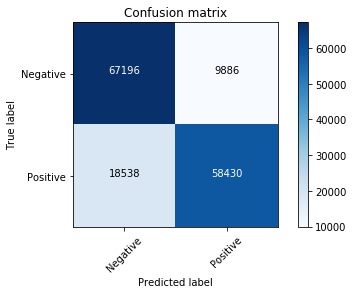

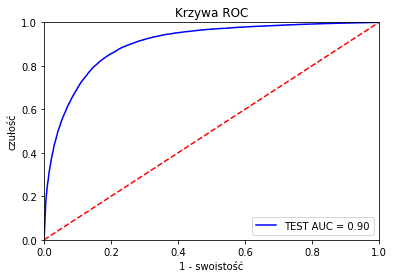

#### Classification report for quadraticdiscriminantanalysis

             precision    recall  f1-score   support

   Negative     0.7708    0.8615    0.8136      4946
   Positive     0.8468    0.7493    0.7951      5054

avg / total     0.8092    0.8048    0.8043     10000



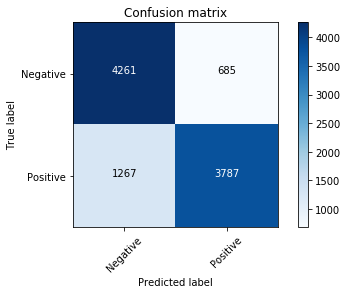

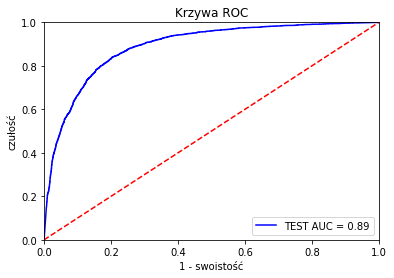

In [13]:
# Due to memory problems lowered amount of samples
qda_limit = min(200000, len(X_sklearn_preprocessed))
qda_model = models.QuadraticDiscriminantAnalysisModel(
    nlp, dataset_id,
    max_words_in_sentence=MAX_WORDS_IN_SENTENCE
)

data = train_model_and_display_results(
    qda_model,
    X_sklearn_preprocessed[:qda_limit], 
    y_train[:qda_limit],
    X_sklearn_test_preprocessed,
    y_test,
    preprocessed=True
)

if SAVE_IN_STORE:
    store.add_model(qda_model, "qda_food", "Food Reviews Quadratic Discriminant Analysis", **data, metadata={
        'Dataset': 'Amazon Fine Food Reviews',
        'Training samples': qda_limit,
        'Description': "Quadratic Discriminant Analysis algorithm from Sklearn package, default options"
    })

## LogisticRegressionModel

#### Overview of created model

None

#### Training

Loading model...
Model 'logisticregression_food_normalized_text_all_90795899.pkl' loaded


#### Model results

#### Predicted scores

,score,text
0,0.981481,"We went there to eat dinner, and it was delicious"
1,0.999985,One of the best suppers I've ever eaten
2,0.000527,Totally disgusting dish. I think cook made this with his eyes closed


#### Classification report for logisticregression

             precision    recall  f1-score   support

   Negative     0.8458    0.8581    0.8519     50060
   Positive     0.8556    0.8432    0.8494     49940

avg / total     0.8507    0.8506    0.8506    100000



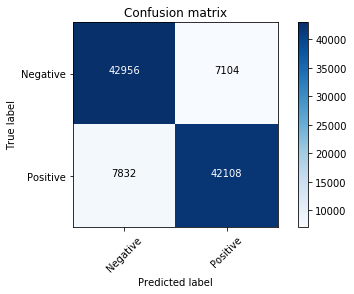

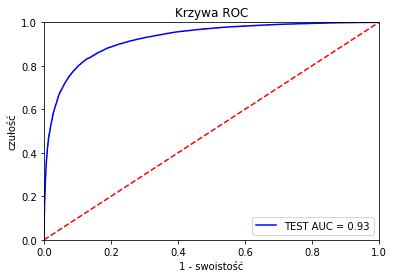

#### Classification report for logisticregression

             precision    recall  f1-score   support

   Negative     0.8389    0.8528    0.8458      4946
   Positive     0.8536    0.8397    0.8466      5054

avg / total     0.8463    0.8462    0.8462     10000



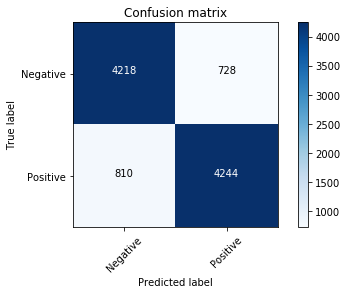

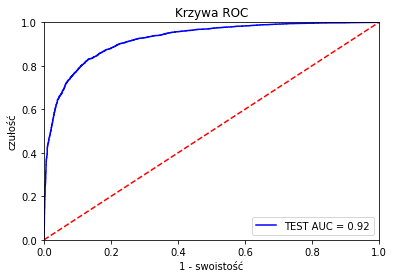

In [14]:
logistic_regression_limit = min(100000, len(X_sklearn_preprocessed))

logistic_regression = models.LogisticRegressionModel(
    nlp, dataset_id,
    max_words_in_sentence=MAX_WORDS_IN_SENTENCE, 
    C=1e5
)

data = train_model_and_display_results(
    logistic_regression,
    X_sklearn_preprocessed[:logistic_regression_limit],
    y_train[:logistic_regression_limit],
    X_sklearn_test_preprocessed,
    y_test,
    preprocessed=True
)

if SAVE_IN_STORE:
    store.add_model(logistic_regression, "logistic_reg_food", "Food Reviews Logistic Regression", **data, metadata={
        'Dataset': 'Amazon Fine Food Reviews',
        'Training samples': logistic_regression_limit,
        'Description': "Logistic Regression Analysis algorithm from Sklearn package, default options except C=1e5"
    })

## GradientBoostingModel

#### Overview of created model

None

#### Training

Loading model...
Model 'gradientboostingclassifier_food_normalized_text_all_c002d57a.pkl' loaded


#### Model results

#### Predicted scores

,score,text
0,0.790866,"We went there to eat dinner, and it was delicious"
1,0.813024,One of the best suppers I've ever eaten
2,0.455834,Totally disgusting dish. I think cook made this with his eyes closed


#### Classification report for gradientboostingclassifier

             precision    recall  f1-score   support

   Negative     0.7808    0.8028    0.7916     77082
   Positive     0.7967    0.7742    0.7853     76968

avg / total     0.7887    0.7885    0.7885    154050



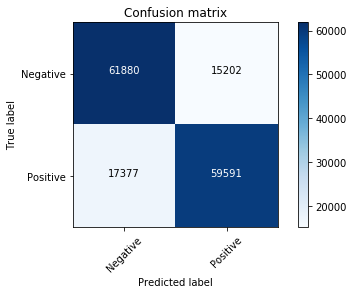

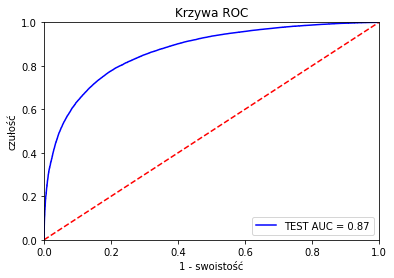

#### Classification report for gradientboostingclassifier

             precision    recall  f1-score   support

   Negative     0.7702    0.8039    0.7867      4946
   Positive     0.7995    0.7653    0.7820      5054

avg / total     0.7850    0.7844    0.7843     10000



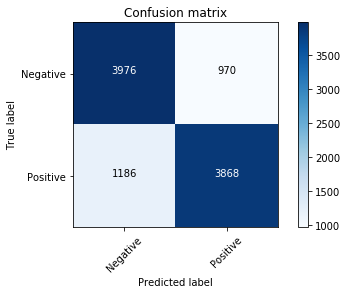

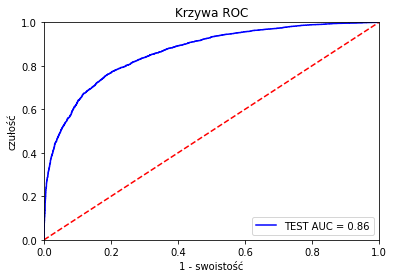

In [15]:
gradient_boosting_model = models.GradientBoostingModel(
    nlp, dataset_id,
    max_words_in_sentence=MAX_WORDS_IN_SENTENCE, 
    n_estimators=50, 
    max_depth=2,
    verbose=2
)

data = train_model_and_display_results(
    gradient_boosting_model,
    X=X_sklearn_preprocessed,
    Xt=X_sklearn_test_preprocessed,
    preprocessed=True
)

if SAVE_IN_STORE:
    store.add_model(gradient_boosting_model, "gradient_boost_food", "Food Reviews Gradient Boosting", **data, metadata={
        'Dataset': 'Amazon Fine Food Reviews',
        'Training samples': len(X_sklearn_preprocessed),
        'Description': "Gradient Boosting algorithm from Sklearn package, n_estimators=50, max_depth=2"
    })

## XGBModel

#### Overview of created model

None

#### Training

Loading model...
Model 'xgbclassifier_food_normalized_text_all_a8948ce7.pkl' loaded


#### Model results

#### Predicted scores

,score,text
0,0.865988,"We went there to eat dinner, and it was delicious"
1,0.938134,One of the best suppers I've ever eaten
2,0.143300,Totally disgusting dish. I think cook made this with his eyes closed


#### Classification report for xgbclassifier

             precision    recall  f1-score   support

   Negative     0.8177    0.8380    0.8278     77082
   Positive     0.8337    0.8129    0.8232     76968

avg / total     0.8257    0.8255    0.8255    154050



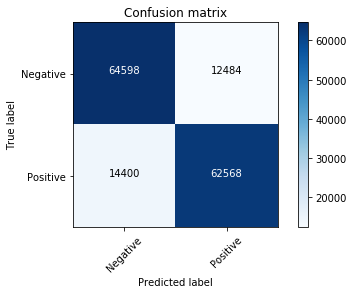

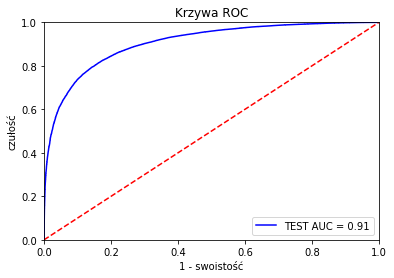

#### Classification report for xgbclassifier

             precision    recall  f1-score   support

   Negative     0.8039    0.8281    0.8159      4946
   Positive     0.8267    0.8023    0.8143      5054

avg / total     0.8154    0.8151    0.8151     10000



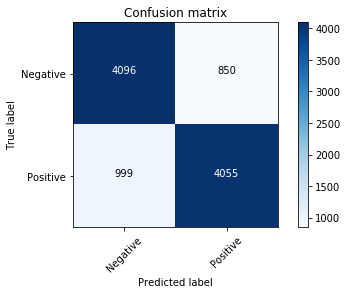

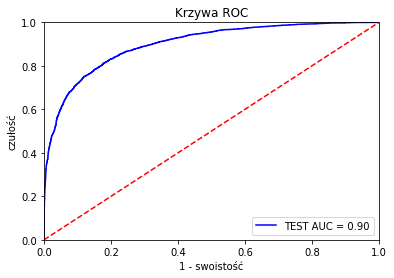

In [16]:
xgb_limit = min(500000, len(X_sklearn_preprocessed))
xgb_model = models.XGBModel(
    nlp, dataset_id, 
    max_words_in_sentence=MAX_WORDS_IN_SENTENCE, 
    verbose_eval=1, silent=False, n_jobs=4
)

data = train_model_and_display_results(
    xgb_model,
    X_sklearn_preprocessed[:xgb_limit],
    y_train[:xgb_limit],
    X_sklearn_test_preprocessed,
    y_test,
    preprocessed=True
)

if SAVE_IN_STORE:
    store.add_model(xgb_model, "xgboost_food", "Food Reviews XGBoost", **data, metadata={
        'Dataset': 'Amazon Fine Food Reviews',
        'Training samples': xgb_limit,
        'Description': "XGBoost using default parameters"
    })